# Video Segmentation Data

This is a demonstration of a single simulation of SEM on a single video.  In practice, this simulation is repeated in multiple batches and over three videos.  We only include one for simplicity and computational resources.

For reasons of space, we have only included the processed video data (embedded with a VAE) in the github repository. The VAE and the code to create this embedding can be found in a seperate repository: [ProjectSEM/VAE-video](https://github.com/ProjectSEM/VAE-video)





In [1]:
# ## un-comment out if running locally

# import os
# os.chdir('../')

In [ ]:
## if running locally, comment out the following code

!git clone https://github.com/nicktfranklin/SEM3.git
import os
os.chdir('./SEM3/')

In [2]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from core.sem import SEM
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

TensorFlow Version: 1.14.0
TensorFlow Check Passed


In [3]:
Z = np.load('data/videodata/video_color_Z_embedded_64_5epoch.npy')


# # the "Sax" movie is from time slices 0 to 5537
# sax = Z[0:5537, :]  # uncomment to use the "saxaphone video"
# bed = Z[5537:5537 + 10071, :]  # uncomment to use the "making the bed"
dishes = Z[5537 + 10071: 5537 + 10071 + 7633, :]
# Z = None


# x = sax[0:1500]
# x = sax
x = dishes


In [5]:
# Load Human comparison data, used later

def bin_times(array, max_seconds, bin_size=1.0):
    """ Helper function to learn the bin the subject data"""
    cumulative_binned = [np.sum(array <= t0 * 1000) for t0 in np.arange(bin_size, max_seconds + bin_size, bin_size)]
    binned = np.array(cumulative_binned)[1:] - np.array(cumulative_binned)[:-1]
    binned = np.concatenate([[cumulative_binned[0]], binned])
    return binned

def load_comparison_data(data, bin_size=1.0):

    # Movie A is Saxaphone (185s long)
    # Movie B is making a bed (336s long)
    # Movie C is doing dishes (255s long)

    # here, we'll collapse over all of the groups (old, young; warned, unwarned) for now
    n_subjs = len(set(data.SubjNum))

    sax_times = np.sort(list(set(data.loc[data.Movie == 'A', 'MS']))).astype(np.float32)
    binned_sax = bin_times(sax_times, 185, bin_size) / np.float(n_subjs)

    bed_times = np.sort(list(set(data.loc[data.Movie == 'B', 'MS']))).astype(np.float32)
    binned_bed = bin_times(bed_times, 336, bin_size) / np.float(n_subjs)

    dishes_times = np.sort(list(set(data.loc[data.Movie == 'C', 'MS']))).astype(np.float32)
    binned_dishes = bin_times(dishes_times, 255, bin_size) / np.float(n_subjs)

    return binned_sax, binned_bed, binned_dishes

human_data_path = './data/'
data = pd.read_csv(human_data_path + 'zachs2006_data021011.dat', delimiter='\t')
_, _, binned_dishes = load_comparison_data(data)

In [6]:
import gc
# clear from memory the original data
Z = None
# gc.

gc.collect()

73

In [7]:
# set the parameters for the segmentation
# f_class = GRUEvent

f_opts=dict(
    var_df0=10., 
    var_scale0=0.06, 
    l2_regularization=0.0, 
    dropout=0.5,
    n_epochs=10,
    t=4
)

lmda = 10**4
alfa = 10**-1

Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
#     'f_class': f_class,
    'f_opts': f_opts
}

In [8]:
# run the model
sem_model = SEM(**Omega)
_ = sem_model.run(x, k=x.shape[0], progress_bar=True)

W0819 14:47:12.844868 4520445376 deprecation_wrapper.py:119] From /Users/nicholasfranklin/OneDrive/Projects/SEM3/core/sem.py:215: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

Run SEM:   0%|          | 0/7633 [00:00<?, ?it/s]W0819 14:47:12.876152 4520445376 deprecation.py:506] From /Users/nicholasfranklin/anaconda3/envs/sem3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0819 14:47:13.563199 4520445376 deprecation.py:323] From /Users/nicholasfranklin/anaconda3/envs/sem3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed i

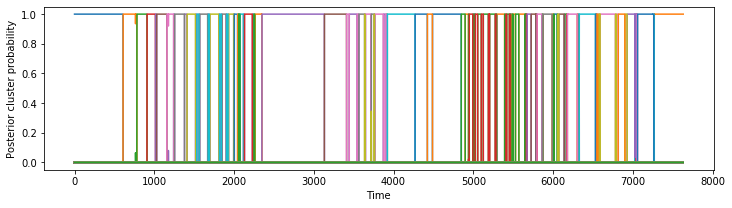

In [9]:
# get the MAP event models
y_hat = sem_model.results.e_hat

plt.figure(figsize=(12, 3.0))
plt.plot(sem_model.results.post)
plt.gca().set_ylabel('Posterior cluster probability')
plt.gca().set_xlabel('Time')
plt.show()
# tf.Session().close()

In [10]:
# these are custom analysis functions

def bin_times(array, max_seconds, bin_size=1.0):
    cumulative_binned = [np.sum(array <= t0 * 1000) for t0 in np.arange(bin_size, max_seconds + bin_size, bin_size)]
    binned = np.array(cumulative_binned)[1:] - np.array(cumulative_binned)[:-1]
    binned = np.concatenate([[cumulative_binned[0]], binned])
    return binned


def get_subjs_rpb(data, bin_size=1.0):
    # get the grouped data
    grouped_data = np.concatenate(load_comparison_data(data))
    
    r_pbs = []
    
    for sj in set(data.SubjNum):
        _binned_sax =  bin_times(data.loc[(data.SubjNum == sj) & (data.Movie == 'A'), 'MS'], 185, 1.0)
        _binned_bed =  bin_times(data.loc[(data.SubjNum == sj) & (data.Movie == 'B'), 'MS'], 336, 1.0)
        _binned_dishes =  bin_times(data.loc[(data.SubjNum == sj) & (data.Movie == 'C'), 'MS'], 255, 1.0)
        subs = np.concatenate([_binned_sax, _binned_bed, _binned_dishes])
        
        r_pbs.append(get_point_biserial(subs, grouped_data))
    return r_pbs
    


In [11]:
# get the point biserial correlation coefficient

def get_binned_boundaries(posterior, bin_size=1.0, frequency=30.0):
    
    e_hat = np.argmax(sem_model.results.post, axis=1)
    
    frame_time = np.arange(1, len(e_hat) + 1) / float(frequency)
    index = np.arange(0, np.max(frame_time), bin_size)

    boundaries = np.concatenate([[0], e_hat[1:] !=e_hat[:-1]])

    boundaries_binned = []
    for t in index:
        boundaries_binned.append(np.sum(
            boundaries[(frame_time >= t) & (frame_time < (t + bin_size))]
        ))
    return np.array(boundaries_binned, dtype=bool) 

def get_point_biserial(boundaries_binned, binned_comp):
    M_1 = np.mean(binned_comp[boundaries_binned == 1])
    M_0 = np.mean(binned_comp[boundaries_binned == 0])

    n_1 = np.sum(boundaries_binned == 1)
    n_0 = np.sum(boundaries_binned == 0)
    n = n_1 + n_0

    s = np.std(binned_comp)
    r_pb = (M_1 - M_0) / s * np.sqrt(n_1 * n_0 / (float(n)**2))
    return r_pb

boundaries = get_binned_boundaries(sem_model.results.post)

get_point_biserial(boundaries, binned_dishes)

0.2743001309540763

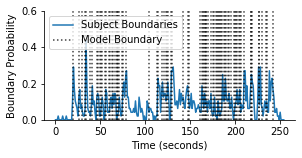

In [12]:
plt.figure(figsize=(4.5, 2.0))
plt.plot(binned_dishes, label='Subject Boundaries')
plt.xlabel('Time (seconds)')
plt.ylabel('Boundary Probability')

b = np.arange(len(boundaries))[boundaries][0]
plt.plot([b, b], [0, 1], 'k:', label='Model Boundary', alpha=0.75)
for b in np.arange(len(boundaries))[boundaries][1:]:
    plt.plot([b, b], [0, 1], 'k:', alpha=0.75)

plt.legend(loc='upper left')
plt.ylim([0, 0.6])
sns.despine()


In [13]:
# from video_segmentation import load_comparison_data
# human_data_path = './data/'
# data = pd.read_csv(human_data_path + 'zachs2006_data021011.dat', delimiter='\t')
# binned_sax, binned_bed, binned_dishes = load_comparison_data(data, bin_size=1.0)

array([130, 238, 211, 210,  79, 131,  20, 228, 226,  34])

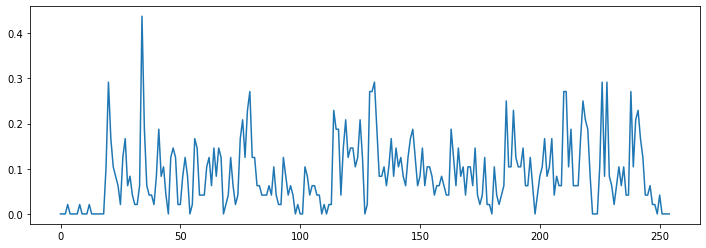

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(binned_dishes, alpha=1.0)
np.argsort(binned_dishes)[-10:]

0.5656171932224218

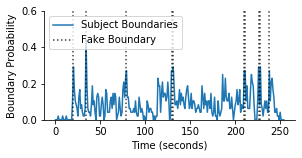

In [15]:
fake_boundaries = np.zeros(np.shape(binned_dishes), dtype=bool) 
fake_boundaries[np.argsort(binned_dishes)[-10:]] = True

plt.figure(figsize=(4.5, 2.0))
plt.plot(binned_dishes, label='Subject Boundaries')
plt.xlabel('Time (seconds)')
plt.ylabel('Boundary Probability')

b = np.arange(len(fake_boundaries))[fake_boundaries][0]
plt.plot([b, b], [0, 1], 'k:', label='Fake Boundary', alpha=0.75)
for b in np.arange(len(fake_boundaries))[fake_boundaries][1:]:
    plt.plot([b, b], [0, 1], 'k:', alpha=0.75)

plt.legend(loc='upper left')
plt.ylim([0, 0.6])
sns.despine()

get_point_biserial(fake_boundaries, binned_dishes)

Maximum possible r_pb: 0.8056334426110205


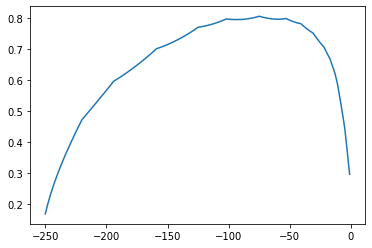

In [18]:
r_pb = []
for ii in range(-250, 0, 1):
    fake_boundaries = np.zeros(np.shape(binned_dishes), dtype=bool) 
    fake_boundaries[np.argsort(binned_dishes)[ii:]] = True
    r_pb.append(get_point_biserial(fake_boundaries, binned_dishes))
plt.plot(range(-250, 0, 1), r_pb)
print("Maximum possible r_pb: {}".format(np.max(r_pb)))

In [20]:
from scipy.special import logsumexp
def get_binned_boundary_prop(log_post, bin_size=1.0, frequency=30.0):
    """
    :param results: SEM.Results
    :param bin_size: seconds
    :param frequency: in Hz
    :return:
    """
    
    e_hat = np.argmax(log_post, axis=1)

    # normalize
    log_post0 = log_post - np.tile(np.max(log_post, axis=1).reshape(-1, 1), (1, log_post.shape[1]))
    log_post0 -= np.tile(logsumexp(log_post0, axis=1).reshape(-1, 1), (1, log_post.shape[1]))

    boundary_probability = [0]
    for ii in range(1, log_post0.shape[0]):
        idx = list(range(log_post0.shape[0]))
        idx.remove(e_hat[ii - 1])
        boundary_probability.append(logsumexp(log_post0[ii, idx]))
    boundary_probability = np.array(boundary_probability)

    frame_time = np.arange(1, len(boundary_probability) + 1) / float(frequency)

    index = np.arange(0, np.max(frame_time), bin_size)
    boundary_probability_binned = []
    for t in index:
        boundary_probability_binned.append(
            # note: this operation is equivalent to the log of the average boundary probability in the window
            logsumexp(boundary_probability[(frame_time >= t) & (frame_time < (t + bin_size))]) - \
            np.log(bin_size * 30.)
        )
    boundary_probability_binned = pd.Series(boundary_probability_binned, index=index)
    return boundary_probability_binned

boundary_prop = get_binned_boundary_prop(sem_model.results.log_prior + sem_model.results.log_like)

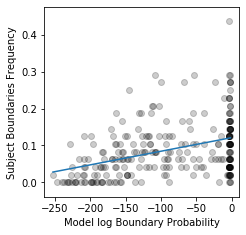

In [21]:
plt.figure(figsize=(3.5, 3.5))
plt.scatter(boundary_prop, binned_dishes, color='k', alpha=0.2)
plt.ylabel('Subject Boundaries Frequency')
plt.xlabel('Model log Boundary Probability')
x = boundary_prop
y = binned_dishes
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))


In [22]:
r_pbs = get_subjs_rpb(data)

In [23]:
# get the permutation r_pb
_boundaries = np.copy(boundaries)
n_permute = 500
r_pb_permuted = []
for ii in range(n_permute):
    np.random.shuffle(_boundaries)
    r_pb_permuted.append(get_point_biserial(_boundaries, binned_dishes))

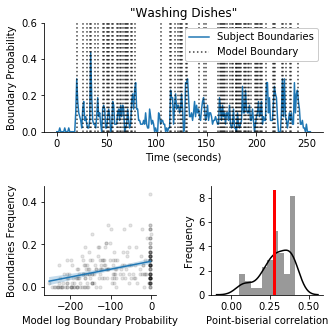

In [24]:
import statsmodels.api as sm
from scipy import stats


plt.figure(figsize=(5.0, 5.0))
ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)

plt.plot(binned_dishes, label='Subject Boundaries')
plt.xlabel('Time (seconds)')
plt.ylabel('Boundary Probability')

b = np.arange(len(boundaries))[boundaries][0]
plt.plot([b, b], [0, 1], 'k:', label='Model Boundary', alpha=0.75)
for b in np.arange(len(boundaries))[boundaries][1:]:
    plt.plot([b, b], [0, 1], 'k:', alpha=0.75)

plt.legend(loc='upper right', framealpha=1.0)
plt.ylim([0, 0.6])
plt.title('"Washing Dishes"')
sns.despine()

ax = plt.subplot2grid((2, 2), (1, 0), colspan=1)
plt.scatter(boundary_prop, binned_dishes, color='k', s=10, alpha=0.1)
plt.ylabel('Boundaries Frequency')
plt.xlabel('Model log Boundary Probability')
x = boundary_prop
y = binned_dishes
y = y[np.argsort(x)]
x = np.sort(x)
X = sm.add_constant(x)
mod = sm.OLS(y, X)
res = mod.fit()
y_hat = res.predict(X)
plt.plot(x, res.predict(X))

n = len(y_hat)
dof = n - res.df_model - 1
t = stats.t.ppf(1-0.025, df=dof)
s_err = np.sum(np.power(y - y_hat, 2))
conf = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((x-np.mean(x)),2) /
            ((np.sum(np.power(x,2))) - n*(np.power(np.mean(x),2))))))

upper = y_hat + abs(conf)
lower = y_hat - abs(conf)
plt.fill_between(x, lower, upper, alpha=0.25)

ax = plt.subplot2grid((2, 2), (1, 1), colspan=1)
x = 'Model Subjects'.split()
sns.distplot(r_pbs,  ax=ax, norm_hist=False, label='Subjects', bins=10, color='k')
r_pb_model = get_point_biserial(boundaries, binned_dishes)
lb, ub = ax.get_ylim()
plt.plot([r_pb_model, r_pb_model], [0, ub], 'r', label='Model', lw='3')
plt.xlabel(r'Point-biserial correlation')
plt.ylabel('Frequency')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
sns.despine()
# plt.savefig('Segmentation_dishes.pdf', dpi=600, bbox_inches='tight')